# 03c_Figure1and3_HSC_LSK_heatmap

Top genes for treatments and clusters were generated with the same method as in Notebook 03b. 

Heatmaps were generated either from the top 50 genes, with 4 representative genes per condition, or plotting everything (without gene names). Eventually the 4 representative genes were included in the Figure 1 (HSCs) and Figure 3 (LSKs). 

Run with this command in docker container:
docker run --rm -d --name scanpy -p 8881:8888 -e JUPYTER_ENABLE_LAB=YES -v /Users/efast/Documents/:/home/jovyan/work scanpy:1.7.2

## 1) Loading packages + data

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from gprofiler import GProfiler
import seaborn as sns; sns.set() 
from helper_functions import *

from upsetplot import UpSet
import re

from scipy import stats
from random import sample

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)

In [2]:
sc.settings.set_figure_params(dpi=80, dpi_save=300, vector_friendly=True)

## HSC

In [3]:
adata = sc.read('/home/jovyan/work/Z_TRASH/sc_objects/LT_preprocessed.h5ad')

adata.var_names_make_unique()

adata.rename_categories('leiden', ['Metabolism', 'Quiescent', 'Activated', 
                                   'Interferon', 'Acute-Activation', 'Cell-cycle'])

/opt/conda/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/opt/conda/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [4]:
# expression of potential Ifng signalling components - check if Type 1 IFN ligands are expressed

adata.var[adata.raw.var_names.str.contains('ifn', case = False)]

,gene_ids,n_cells,highly_variable,means,dispersions,dispersions_norm
Ifnz,ENSMUSG00000096854,25,False,-4.406909e-17,-2.907234e+13,0.731107
Ifngr1,ENSMUSG00000020009,7927,True,6.213721e-15,4.915957e+13,1.230423
Ifnar2,ENSMUSG00000022971,4121,False,-4.680651e-15,-3.375867e+13,0.284477
Ifnar1,ENSMUSG00000022967,3015,False,3.525296e-15,3.436958e+13,-0.473910
Ifngr2,ENSMUSG00000022965,1977,False,4.293913e-15,1.907734e+13,-1.254081


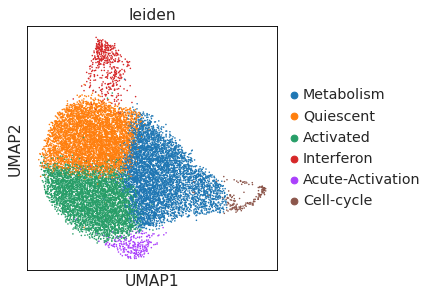

In [5]:
sc.pl.umap(adata, color='leiden')

In [6]:
# make new column in adata.obs for cluster sample
adata.obs['cluster_sample'] = adata.obs['sample'].str.cat(others = adata.obs['leiden'], sep='_')
adata.obs['cluster_sample']=adata.obs['cluster_sample'].astype('category', copy=True) # make a column with category as dtype

In [7]:
adata.obs['cluster_sample'].value_counts()

ct_Quiescent               1981
indo_Activated             1947
ct_Metabolism              1865
indo_Quiescent             1816
indo_Metabolism            1757
ct_Activated               1556
GCSF_Metabolism            1204
GCSF_Quiescent              937
GCSF_Activated              780
pIC_Interferon              316
dmPGE2_Acute-Activation     261
pIC_Metabolism              188
pIC_Quiescent               184
dmPGE2_Activated            108
dmPGE2_Metabolism            83
ct_Cell-cycle                79
indo_Interferon              58
pIC_Activated                58
indo_Cell-cycle              47
GCSF_Cell-cycle              42
ct_Interferon                40
dmPGE2_Quiescent             24
GCSF_Interferon              21
pIC_Cell-cycle                2
indo_Acute-Activation         1
Name: cluster_sample, dtype: int64

### calculate overlap

In [8]:
cols_HSCs = ['primerid',
 'Unnamed: 0',
 'Pr(>Chisq)',
 'coef',
 'FDR',
 'Unnamed: 0LT_1',
 'Pr(>Chisq)LT_1',
 'coefLT_1',
 'FDRLT_1',
 'Unnamed: 0LT_2',
 'Pr(>Chisq)LT_2',
 'coefLT_2',
 'FDRLT_2',
 'Unnamed: 0LT_3',
 'Pr(>Chisq)LT_3',
 'coefLT_3',
 'FDRLT_3',
 'Unnamed: 0LT_4',
 'Pr(>Chisq)LT_4',
 'coefLT_4',
 'FDRLT_4',
 'Unnamed: 0LT_5',
 'Pr(>Chisq)LT_5',
 'coefLT_5',
 'FDRLT_5',
 'Unnamed: 0LT_all',
 'Pr(>Chisq)LT_all',
 'coefLT_all',
 'FDRLT_all']
cols_MPPs = ['primerid', 'Unnamed: 0MPPs_0',
 'Pr(>Chisq)MPPs_0',
 'coefMPPs_0',
 'FDRMPPs_0',
 'Unnamed: 0MPPs_1',
 'Pr(>Chisq)MPPs_1',
 'coefMPPs_1',
 'FDRMPPs_1',
 'Unnamed: 0MPPs_2',
 'Pr(>Chisq)MPPs_2',
 'coefMPPs_2',
 'FDRMPPs_2',
 'Unnamed: 0MPPs_3',
 'Pr(>Chisq)MPPs_3',
 'coefMPPs_3',
 'FDRMPPs_3',
 'Unnamed: 0MPPs_4',
 'Pr(>Chisq)MPPs_4',
 'coefMPPs_4',
 'FDRMPPs_4',
 'Unnamed: 0MPPs_5',
 'Pr(>Chisq)MPPs_5',
 'coefMPPs_5',
 'FDRMPPs_5',
 'Unnamed: 0MPPs_6',
 'Pr(>Chisq)MPPs_6',
 'coefMPPs_6',
 'FDRMPPs_6',
 'Unnamed: 0MPPs_7',
 'Pr(>Chisq)MPPs_7',
 'coefMPPs_7',
 'FDRMPPs_7',
 'Unnamed: 0MPPs_all',
 'Pr(>Chisq)MPPs_all',
 'coefMPPs_all',
 'FDRMPPs_all']

In [9]:
cluster_genes = pd.read_csv('/home/jovyan/work/Z_TRASH/write/all_HSC_clusters_final_all_genes.csv')

In [10]:
cl_list = ['Metabolism', 'Quiescent', 'Activated', 'Interferon', 'Acute-Activation', 'Cell-cycle']

df_temp =pd.DataFrame(columns=['primerid', 'specific', 'score'])
df = pd.DataFrame()

for cl in cl_list:
    results_df = pd.DataFrame(columns=['primerid', 'specific', 'score'])
    column_name = cl + '_n'
    sort_column = cl + '_s'
    column_pval = cl + '_p'
    column_fch = cl + '_l'
    
    
    genelist = cluster_genes[(cluster_genes[column_pval] < 0.05) & \
                             (cluster_genes[column_fch] > math.log2(1))][column_name].tolist()[:200]
    
    scorelist = cluster_genes[(cluster_genes[column_pval] < 0.05) & \
                             (cluster_genes[column_fch] > math.log2(1))][sort_column].tolist()[:200]
    
    
    string_list = [cl] * len(genelist)
    
    results_df['primerid'] = genelist
    results_df['specific'] = string_list
    results_df['score'] = scorelist
    
    df_temp = df_temp.append(results_df, ignore_index=True)

df_temp = df_temp.sort_values(by='score', ascending=False) # this is to get rid of duplicates
df_temp = df_temp.drop_duplicates(subset=['primerid'], keep='first') #keep the ones with the highest score

cl_list = ['Metabolism', 'Quiescent', 'Activated', 'Interferon', 'Acute-Activation', 'Cell-cycle']
top_genes = 100

for cl in cl_list:
    results_df = pd.DataFrame()
        
    genelist = df_temp[df_temp['specific']==cl].sort_values(by='score', ascending=False)['primerid'][:top_genes].tolist()
    
    string_list = [cl] * len(genelist)
    results_df['specific'] = string_list
    results_df['primerid'] = genelist
    
    df = df.append(results_df, ignore_index=True)

HSC_cl = df[['primerid', 'specific']]

In [11]:
files = ['1.2', '1.5', 'nocutoff']
file = '1.2'
treatments = ['dmPGE2', 'GCSF', 'pIC', 'indo']

df_st =pd.DataFrame()
HSC_tx =pd.DataFrame()

for treatment in treatments:
    base_file = '/home/jovyan/work/Z_TRASH/write/'
    file_name = base_file + '/MAST_overlap_' + file + '_' + treatment + '_all.csv'
    df_temp = pd.read_csv(file_name)
    df_temp = df_temp[cols_HSCs]
    df_temp = df_temp.dropna(axis=0, thresh=2) #drop genes with 'NAs'
    df_temp['specific'] = treatment
    df_st = df_st.append(df_temp)

df_st['max_coef'] = df_st.filter(regex='coef').max(axis=1)   
df_st = df_st.sort_values(by='max_coef', ascending=False) # this is to get rid of duplicates
df_st = df_st.drop_duplicates(subset=['primerid'], keep='first') #keep the ones with the highest score


for treatment in treatments:
    results_df = pd.DataFrame()
        
    genelist = df_st[df_st['specific'] == treatment]['primerid'][:top_genes].tolist()
    
    string_list = [treatment] * len(genelist)
    results_df['specific'] = string_list
    results_df['primerid'] = genelist
    
    HSC_tx = HSC_tx.append(results_df, ignore_index=True)

df = df.append(HSC_tx, ignore_index=True)    

In [12]:
genen_before = len(df)
diff_expr = len(df[(df['specific']=='indo') |(df['specific']=='dmPGE2') |\
                   (df['specific']=='pIC') |(df['specific']=='GCSF')])

cl_genes = genen_before - diff_expr

df_all = df.copy()
df_HSC =df.copy()
df_all['duplicated']=df_all['primerid'].duplicated(keep=False)
df = df.drop_duplicates(subset=['primerid'], keep='first') #keep the cluster IDs
genen_after = len(df)
overlap = genen_before - genen_after

print('overlapping genes cluster and diff expression', overlap)

print('proportion of diff expression', overlap/diff_expr)
print('proportion of clusters', overlap/cl_genes)

dic_genes = df.groupby('specific')['primerid'].apply(list).to_dict()

overlapping genes cluster and diff expression 194
proportion of diff expression 0.6339869281045751
proportion of clusters 0.3233333333333333


In [13]:
df['specific'].value_counts()

Quiescent           100
Cell-cycle          100
Interferon          100
Activated           100
Acute-Activation    100
Metabolism          100
GCSF                 64
dmPGE2               28
pIC                  19
indo                  1
Name: specific, dtype: int64

In [14]:
df_all['specific'].value_counts()

Quiescent           100
Cell-cycle          100
Interferon          100
Activated           100
pIC                 100
Acute-Activation    100
dmPGE2              100
GCSF                100
Metabolism          100
indo                  6
Name: specific, dtype: int64

In [15]:
df_all = df.copy()

### Heatmap selected

In [16]:
small_clusters = adata.obs['cluster_sample'].value_counts()[adata.obs['cluster_sample'].value_counts()<20].index.tolist() 
adata_n = adata[~adata.obs['cluster_sample'].isin(small_clusters)].copy()

### no overlap

In [17]:
top_genes = 50
pIC_list = df[df['specific'] == 'pIC']['primerid'].tolist()[:top_genes]
dmPGE2_list = df[df['specific'] == 'dmPGE2']['primerid'].tolist()[:top_genes]
GCSF_list = df[df['specific'] == 'GCSF']['primerid'].tolist()[:top_genes]
indo_list = df[df['specific'] == 'indo']['primerid'].tolist()[:top_genes]

Interferon_list = df[df['specific'] == 'Interferon']['primerid'].tolist()[:top_genes]
Quiescent_list = df[df['specific'] == 'Quiescent']['primerid'].tolist()[:top_genes]
Activated_list = df[df['specific'] == 'Activated']['primerid'].tolist()[:top_genes]
AcuteActivation_list = df[df['specific'] == 'Acute-Activation']['primerid'].tolist()[:top_genes]
Metabolism_list = df[df['specific'] == 'Metabolism']['primerid'].tolist()[:top_genes]
Cellcycle_list = df[df['specific'] == 'Cell-cycle']['primerid'].tolist()[:top_genes]

marker_dic = {'Poly(I:C)' : pIC_list,
              'Interferon': Interferon_list,
              'Quiescent': Quiescent_list,
              #'Indo':indo_list,
              'Activated': Activated_list,
              'Acute-Activation/dmPGE2': AcuteActivation_list,
              #'dmPGE2'    : dmPGE2_list,
              'G-CSF'     : GCSF_list,
              'Metabolism': Metabolism_list,
              'Cell cycle': Cellcycle_list,
               }

In [18]:
# Order of the lineage
lin = ('ct_Interferon', 'indo_Interferon', 'GCSF_Interferon', 'pIC_Interferon', 
       'ct_Quiescent', 'indo_Quiescent', 'GCSF_Quiescent', 'pIC_Quiescent', 'dmPGE2_Quiescent', 
       'ct_Activated', 'indo_Activated', 'GCSF_Activated', 'pIC_Activated', 'dmPGE2_Activated', 'dmPGE2_Acute-Activation', 
       'ct_Metabolism', 'indo_Metabolism', 'GCSF_Metabolism', 'pIC_Metabolism','dmPGE2_Metabolism',
       'ct_Cell-cycle', 'indo_Cell-cycle', 'GCSF_Cell-cycle'
       )

# Reordering leiden labels using Categorical data type
adata_n.obs['cluster_sample'] = adata_n.obs['cluster_sample'].cat.reorder_categories((lin), ordered=True)

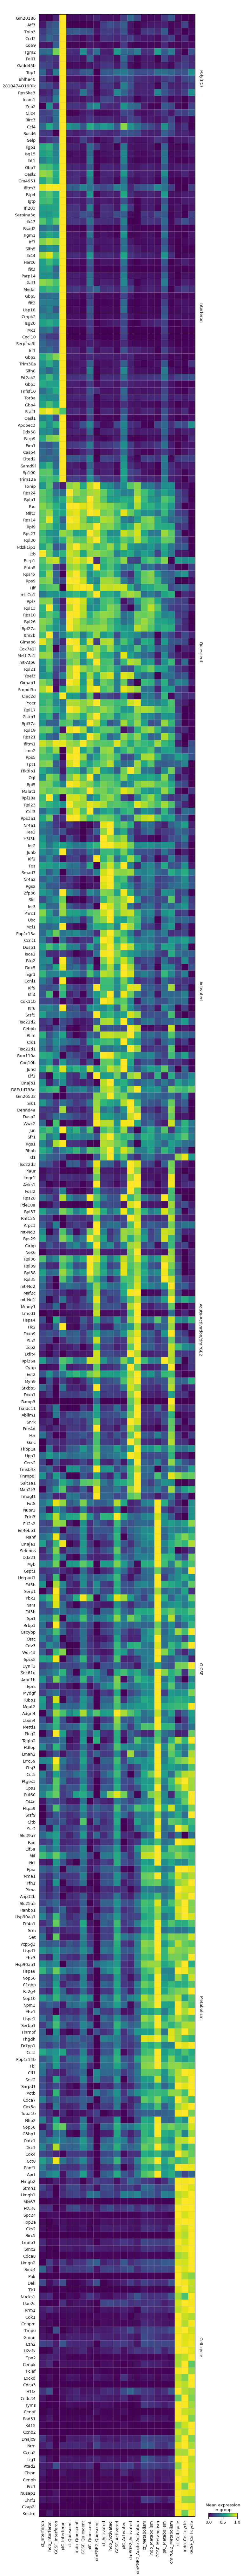

In [19]:
sc.pl.matrixplot(adata_n, marker_dic, 
                 'cluster_sample', standard_scale='var', cmap = 'viridis', swap_axes = True, save='HSCs_top50.pdf')

In [20]:
Metabolism_list = ['Eif5a', 'Ncl', 'Hsp90aa1', 'Nme1']
GCSF_list = [ 'Myb', 'Spi1',  'Nupr1', 'Eif4ebp1']
# depending on what audrey thinks Kit maybe, Plcg2 is not in top 20'Nupr1', 'Gspt1'Wdr43Srsf9
Interferon_list = ['Iigp1','Isg15','Ifit1', 'Oasl2'] # that works
polyIC_list = ['Atf3', 'Peli1', 'Rps6ka3', 'Tnip3']
Quiescent_list = ['Txnip', 'Mllt3', 'Hlf', 'Rps14']
# Procr didn't make it
Activated_list = ['Nr4a1','Ier2','Fos', 'Klf2' ]
#'Ier2'
AcuteActivation_list = ['Fosl2', 'Pde4d', 'Pde10a','Tsc22d3']
Cellcycle_list = ['Mki67' ,'Top2a', 'Cdk1', 'Spc24']

marker_dic = {'Poly(I:C)': polyIC_list,
              'Interferon': Interferon_list,
              'Quiescent': Quiescent_list,
              'Activated': Activated_list,
              'Acute-Activation/dmPGE2': AcuteActivation_list,
              'G-CSF': GCSF_list,
              'Metabolism': Metabolism_list,
              'Cell cycle': Cellcycle_list    
              }

In [21]:
#This is to make sure genes are part of the list

cl_lists = [Metabolism_list, GCSF_list, Interferon_list, polyIC_list, Quiescent_list, Activated_list, AcuteActivation_list, Cellcycle_list]

for cl_list in cl_lists:
    boolean_series = df['primerid'].isin(cl_list).tolist()
    print(cl_list)
    print(boolean_series.count(True))

['Eif5a', 'Ncl', 'Hsp90aa1', 'Nme1']
4
['Myb', 'Spi1', 'Nupr1', 'Eif4ebp1']
4
['Iigp1', 'Isg15', 'Ifit1', 'Oasl2']
4
['Atf3', 'Peli1', 'Rps6ka3', 'Tnip3']
4
['Txnip', 'Mllt3', 'Hlf', 'Rps14']
4
['Nr4a1', 'Ier2', 'Fos', 'Klf2']
4
['Fosl2', 'Pde4d', 'Pde10a', 'Tsc22d3']
4
['Mki67', 'Top2a', 'Cdk1', 'Spc24']
4


In [22]:
# good one!

# Order of the lineage
lin = ('ct_Interferon', 'indo_Interferon', 'GCSF_Interferon', 'pIC_Interferon', 
       'ct_Quiescent', 'indo_Quiescent', 'GCSF_Quiescent', 'pIC_Quiescent', 'dmPGE2_Quiescent', 
       'ct_Activated', 'indo_Activated', 'GCSF_Activated', 'pIC_Activated', 'dmPGE2_Activated', 'dmPGE2_Acute-Activation', 
       'ct_Metabolism', 'indo_Metabolism', 'GCSF_Metabolism', 'pIC_Metabolism','dmPGE2_Metabolism',
       'ct_Cell-cycle', 'indo_Cell-cycle', 'GCSF_Cell-cycle'
       )

# Reordering leiden labels using Categorical data type
adata_n.obs['cluster_sample'] = adata_n.obs['cluster_sample'].cat.reorder_categories((lin), ordered=True)

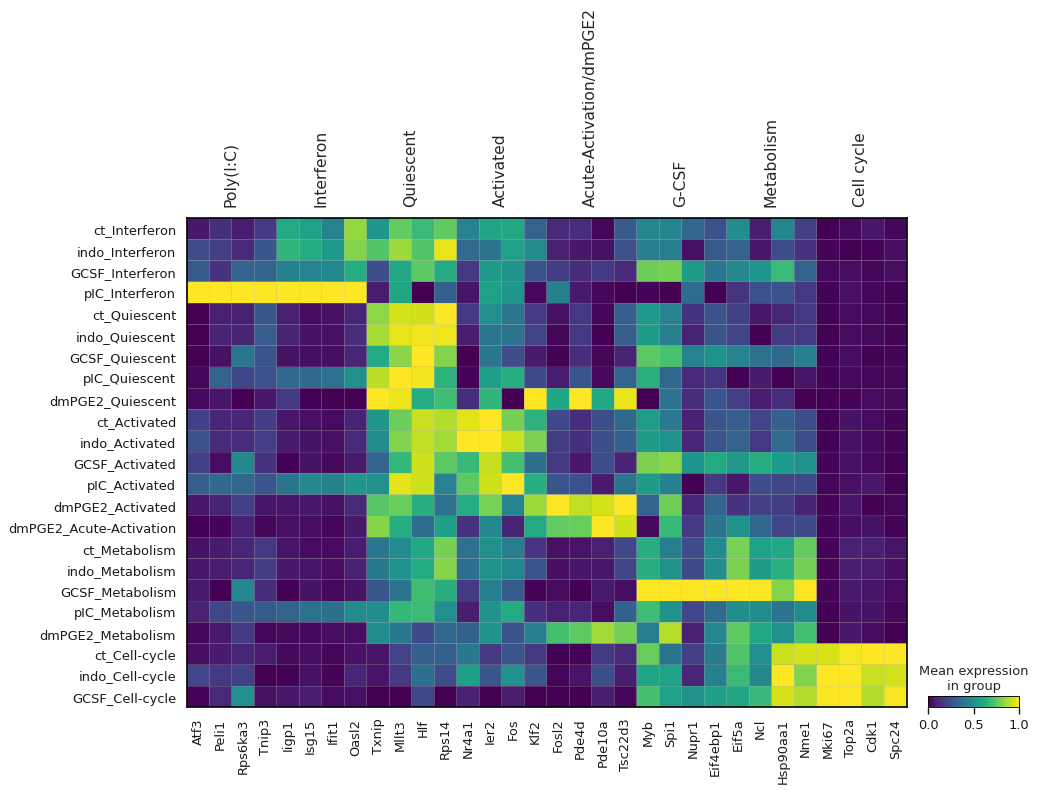

In [23]:
sc.pl.matrixplot(adata_n, marker_dic, 
                 'cluster_sample', standard_scale='var', cmap = 'viridis', save='HSCs_selected.pdf')

/opt/conda/lib/python3.9/site-packages/scanpy/plotting/_matrixplot.py:222: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  _ = ax.pcolor(_color_df, **kwds)


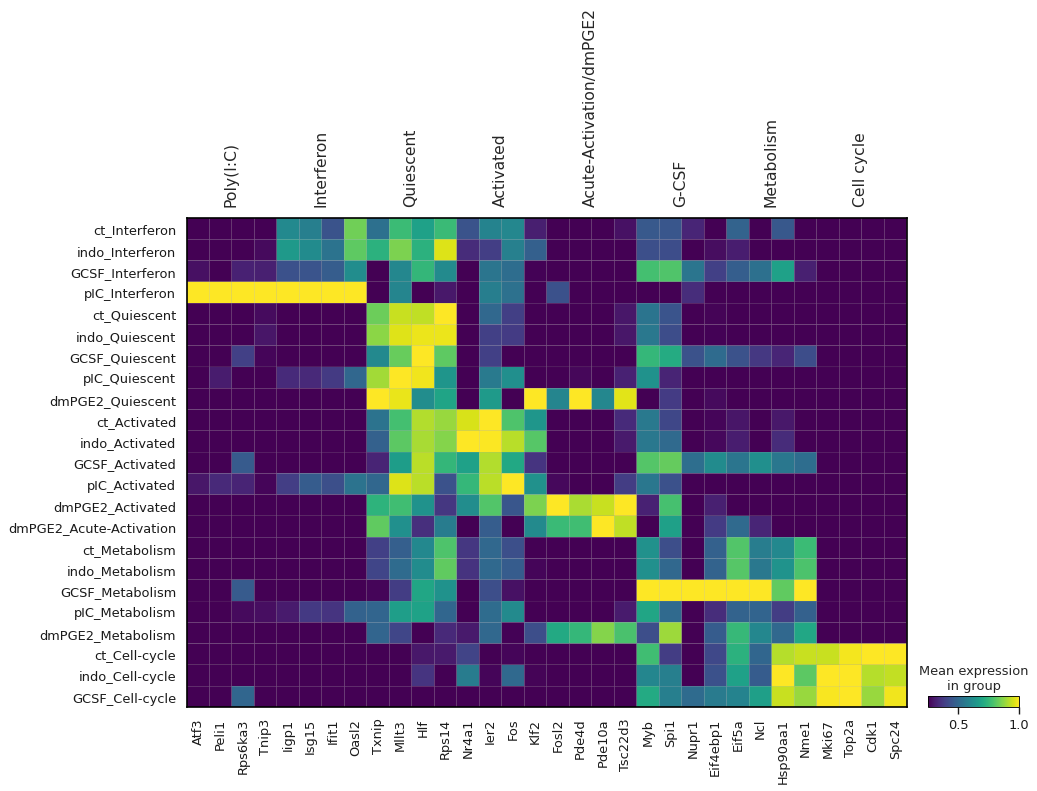

In [24]:
sc.pl.matrixplot(adata_n, marker_dic, 
                 'cluster_sample', standard_scale='var', vmin = 0.25, cmap = 'viridis', save='HSCs_selected_vmin.pdf')

### Heatmap all

In [25]:
# calculate average expression per cluster
hvar_avg = average_expression(adata, dic_genes, gene_symbol_key=None, partition_key='cluster_sample')

In [26]:
small_clusters = adata.obs['cluster_sample'].value_counts()[adata.obs['cluster_sample'].value_counts()<20].index.tolist() 
small_clusters_remove = small_clusters.append('specific')

In [27]:
# define categories and colors for plotting (make a look up table = lut)
lut = dict(zip(hvar_avg['specific'].unique(), ['#ff7f0e', '#d62728', '#8c564b', '#28B463', 
                                               '#aa40fc', '#279e68', '#1f77b4', '#EC7063', '#2E86C1',  '#884EA0']))
row_colors = hvar_avg['specific'].map(lut)

In [28]:
z = list(set(hvar_avg.columns.tolist()) - set(small_clusters))
hvar_avg_subset = hvar_avg[z]

/opt/conda/lib/python3.9/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


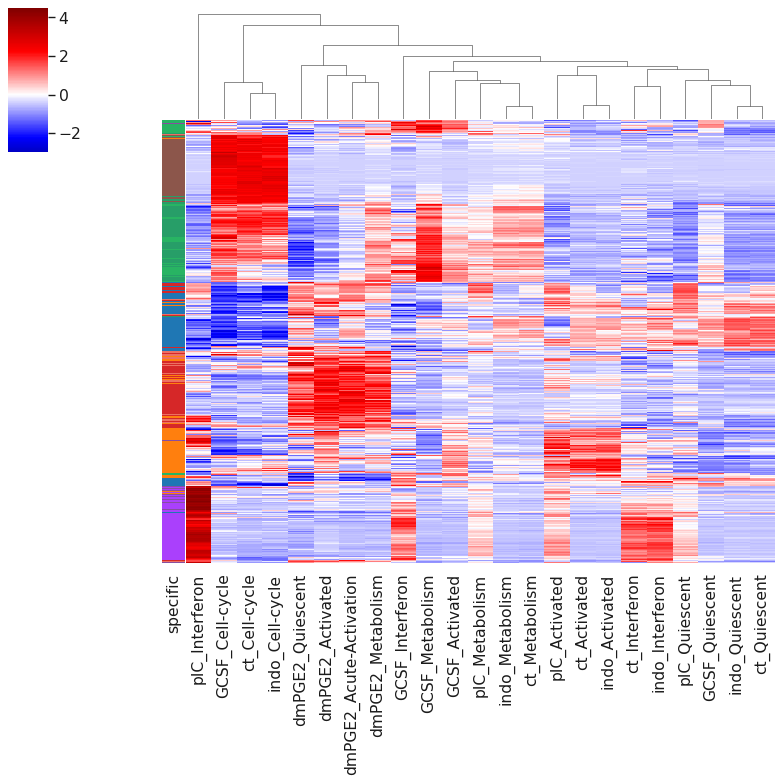

In [29]:
sns_plot = sns.clustermap(hvar_avg_subset,
                          col_cluster=True,
                          row_cluster=True,
                          z_score=0,
                          method= 'average',
                          metric = 'euclidean',
                          cmap = 'seismic',
                          xticklabels=True,
                          yticklabels=False,
                          row_colors = row_colors,
                          #vmin=-3,
                          #vmax=4.5,
                          center=0
                         )

sns_plot.ax_row_dendrogram.set_visible(False)
#plt.setp(sns_plot.cax.yaxis.get_majorticklabels(), fontsize=10)
sns_plot.savefig("/home/jovyan/work/Z_TRASH/figures/HSC_combo_heatmap_aug21.pdf", dpi=300)

## LSK

In [30]:
adata = sc.read('/home/jovyan/work/Z_TRASH/sc_objects/MPP_preprocessed.h5ad')

adata.var_names_make_unique()

# rename cluster categories
adata.rename_categories('leiden', ['Primed', 'Metabolism', 'Progenitor', 'Cell-cycle', 'Acute-Activation', 
                                   'Interferon', 'Interferon cell-cycle','Myeloid'])
# rename LT with HSC
HSPC_renaming = {'LT': 'HSC'} # dictionary for renaming
adata.obs = adata.obs.replace(HSPC_renaming)

# reassign colors
adata.uns['leiden_colors'] = ['#b5bd61', '#279e68', '#1f77b4','#8c564b', '#d62728',
                              '#aa40fc', '#e377c2',  'tab:cyan']

adata.uns['sample_colors'] = ['#A6ACAF', '#2E86C1', '#28B463', '#EC7063', '#884EA0']

adata.uns['assignment_colors'] = ['k', 'olivedrab', 'blue',  'firebrick', 'darkgrey' ]

adata

/opt/conda/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/opt/conda/lib/python3.9/site-packages/anndata/compat/__init__.py:180: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


AnnData object with n_obs × n_vars = 8191 × 13827
    obs: 'assignment', 'batch', 'counts', 'demux_type', 'hto_type', 'rna_type', 'sample', 'select_cells', 'n_counts', 'log_counts', 'n_genes', 'percent_mito', 'Female', 'Female_cat', 'Female_str', 'sex_sample', 'rXist', 'leiden', 'umap_density_sample', 'umap_density_assignment'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'assignment_colors', 'diffmap_evals', 'draw_graph', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'sample_colors', 'sex_sample_colors', 'umap', 'umap_density_assignment_params', 'umap_density_sample_params'
    obsm: 'X_diffmap', 'X_draw_graph_fr', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [31]:
# expression of potential Ifng signalling components

adata.var[adata.raw.var_names.str.contains('ifn', case = False)]

,gene_ids,feature_types,n_cells,highly_variable,means,dispersions,dispersions_norm
Ifngr1,ENSMUSG00000020009,Gene Expression,5923,False,-1.756622e-15,-2.451609e+14,-4.301049
Ifnar2,ENSMUSG00000022971,Gene Expression,4346,True,1.543225e-15,1.212927e+14,1.228629
Ifnar1,ENSMUSG00000022967,Gene Expression,2431,False,-1.175419e-16,-9.431172e+14,-7.642783
Ifngr2,ENSMUSG00000022965,Gene Expression,1908,False,-5.146794e-16,-1.727800e+14,-0.894945


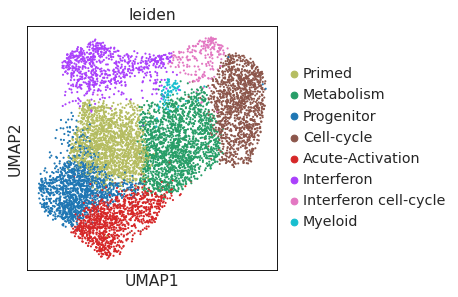

In [32]:
sc.pl.umap(adata, color='leiden')

In [33]:
# make new column in adata.obs for cluster sample
adata.obs['cluster_sample'] = adata.obs['sample'].str.cat(others = adata.obs['leiden'], sep='_')
adata.obs['cluster_sample']=adata.obs['cluster_sample'].astype('category', copy=True) # make a column with category as dtype

### overlap

In [34]:
cluster_genes = pd.read_csv('/home/jovyan/work/Z_TRASH/write/all_MPP_clusters_final_all_genes.csv')

In [35]:
cl_list = ['Primed', 'Metabolism', 'Progenitor', 'Cell-cycle', 'Acute-Activation', 
                                   'Interferon', 'Interferon cell-cycle','Myeloid']

df_temp =pd.DataFrame(columns=['primerid', 'specific', 'score'])
df = pd.DataFrame()

for cl in cl_list:
    results_df = pd.DataFrame(columns=['primerid', 'specific', 'score'])
    column_name = cl + '_n'
    sort_column = cl + '_s'
    column_pval = cl + '_p'
    column_fch = cl + '_l'
    
    
    genelist = cluster_genes[(cluster_genes[column_pval] < 0.05) & \
                             (cluster_genes[column_fch] > math.log2(1))][column_name].tolist()[:200]
    
    scorelist = cluster_genes[(cluster_genes[column_pval] < 0.05) & \
                             (cluster_genes[column_fch] > math.log2(1))][sort_column].tolist()[:200]
    
    
    string_list = [cl] * len(genelist)
    
    results_df['primerid'] = genelist
    results_df['specific'] = string_list
    results_df['score'] = scorelist
    
    df_temp = df_temp.append(results_df, ignore_index=True)

df_temp = df_temp.sort_values(by='score', ascending=False) # this is to get rid of duplicates
df_temp = df_temp.drop_duplicates(subset=['primerid'], keep='first') #keep the ones with the highest score

top_genes = 100

for cl in cl_list:
    results_df = pd.DataFrame()
        
    genelist = df_temp[df_temp['specific']==cl].sort_values(by='score', ascending=False)['primerid'][:top_genes].tolist()
    
    string_list = [cl] * len(genelist)
    results_df['specific'] = string_list
    results_df['primerid'] = genelist
    
    df = df.append(results_df, ignore_index=True)

MPP_cl = df[['primerid', 'specific']]

In [36]:
files = ['1.2', '1.5', 'nocutoff']
file = '1.2'
treatments = ['dmPGE2', 'GCSF', 'pIC', 'indo']

df_st =pd.DataFrame()
MPP_tx = pd.DataFrame()

for treatment in treatments:
    base_file = '/home/jovyan/work/Z_TRASH/write/'
    file_name = base_file + '/MAST_overlap_' + file + '_' + treatment + '_all.csv'
    df_temp = pd.read_csv(file_name)
    df_temp = df_temp[cols_MPPs]
    df_temp = df_temp.dropna(axis=0, thresh=2) #drop genes with 'NAs'
    df_temp['specific'] = treatment
    df_st = df_st.append(df_temp)

df_st['max_coef'] = df_st.filter(regex='coef').max(axis=1)   
df_st = df_st.sort_values(by='max_coef', ascending=False) # this is to get rid of duplicates
df_st = df_st.drop_duplicates(subset=['primerid'], keep='first') #keep the ones with the highest score


for treatment in treatments:
    results_df = pd.DataFrame()
        
    genelist = df_st[df_st['specific'] == treatment]['primerid'][:top_genes].tolist()
    
    string_list = [treatment] * len(genelist)
    results_df['specific'] = string_list
    results_df['primerid'] = genelist
    
    MPP_tx = MPP_tx.append(results_df, ignore_index=True)

df = df.append(MPP_tx, ignore_index=True)    

In [37]:
genen_before = len(df)
diff_expr = len(df[(df['specific']=='indo') |(df['specific']=='dmPGE2') |\
                   (df['specific']=='pIC') |(df['specific']=='GCSF')])

cl_genes = genen_before - diff_expr

df_all = df.copy()
df_all['duplicated']=df_all['primerid'].duplicated(keep=False)
df = df.drop_duplicates(subset=['primerid'], keep='first') #keep the cluster IDs
genen_after = len(df)
overlap = genen_before - genen_after

print('overlapping genes cluster and diff expression', overlap)

print('proportion of diff expression', overlap/diff_expr)
print('proportion of clusters', overlap/cl_genes)

dic_genes = df.groupby('specific')['primerid'].apply(list).to_dict()

overlapping genes cluster and diff expression 189
proportion of diff expression 0.627906976744186
proportion of clusters 0.2680851063829787


In [38]:
df['specific'].value_counts()

Primed                   100
Myeloid                  100
Cell-cycle               100
Interferon               100
Acute-Activation         100
Progenitor               100
Metabolism               100
GCSF                      81
dmPGE2                    22
pIC                        8
Interferon cell-cycle      5
indo                       1
Name: specific, dtype: int64

In [39]:
df_all['specific'].value_counts()

Primed                   100
Myeloid                  100
Cell-cycle               100
Interferon               100
pIC                      100
Acute-Activation         100
Progenitor               100
dmPGE2                   100
GCSF                     100
Metabolism               100
Interferon cell-cycle      5
indo                       1
Name: specific, dtype: int64

### Heatmaps

In [40]:
adata.obs['cluster_sample'].value_counts()

dmPGE2_Acute-Activation       1073
pIC_Interferon                 713
GCSF_Primed                    549
indo_Primed                    459
GCSF_Metabolism                458
pIC_Primed                     439
GCSF_Progenitor                420
indo_Progenitor                388
indo_Metabolism                385
dmPGE2_Cell-cycle              373
dmPGE2_Metabolism              334
pIC_Metabolism                 315
GCSF_Cell-cycle                251
pIC_Progenitor                 246
ct_Primed                      246
ct_Progenitor                  237
indo_Cell-cycle                236
ct_Metabolism                  223
pIC_Cell-cycle                 211
pIC_Interferon cell-cycle      196
ct_Cell-cycle                  148
dmPGE2_Progenitor              140
dmPGE2_Myeloid                  40
dmPGE2_Primed                   31
pIC_Myeloid                     20
indo_Interferon                 13
GCSF_Acute-Activation           10
GCSF_Myeloid                     9
ct_Acute-Activation 

In [41]:
small_clusters = adata.obs['cluster_sample'].value_counts()[adata.obs['cluster_sample'].value_counts()<20].index.tolist() 
adata_n = adata[~adata.obs['cluster_sample'].isin(small_clusters)].copy()

In [42]:
top_genes = 50
pIC_list = df[df['specific'] == 'pIC']['primerid'].tolist()[:top_genes]
dmPGE2_list = df[df['specific'] == 'dmPGE2']['primerid'].tolist()[:top_genes]
GCSF_list = df[df['specific'] == 'GCSF']['primerid'].tolist()[:top_genes]
indo_list = df[df['specific'] == 'indo']['primerid'].tolist()[:top_genes]

Interferon_list = df[df['specific'] == 'Interferon']['primerid'].tolist()[:top_genes]
Progenitor_list = df[df['specific'] == 'Progenitor']['primerid'].tolist()[:top_genes]
Primed_list = df[df['specific'] == 'Primed']['primerid'].tolist()[:top_genes]
AcuteActivation_list = df[df['specific'] == 'Acute-Activation']['primerid'].tolist()[:top_genes]
Metabolism_list = df[df['specific'] == 'Metabolism']['primerid'].tolist()[:top_genes]
Cellcycle_list = df[df['specific'] == 'Cell-cycle']['primerid'].tolist()[:top_genes]
Interferoncellcycle_list = df[df['specific'] == 'Interferon cell-cycle']['primerid'].tolist()[:top_genes] 
Myloid_list = df[df['specific'] == 'Myeloid']['primerid'].tolist()[:top_genes] 

marker_dic = {#'dmPGE2'    : dmPGE2_list,
              'Acute-Activation/dmPGE2': AcuteActivation_list,
              'Progenitor': Progenitor_list,
              'Primed': Primed_list,
              'Metabolism': Metabolism_list,
              'G-CSF'     : GCSF_list,
              'Cell cycle': Cellcycle_list,
              'Interferon cell-cycle/Poly(I:C)': Interferoncellcycle_list,
              'Interferon/Poly(I:C)': Interferon_list,
              #'Poly(I:C)' : pIC_list,
              'Myeloid':  Myloid_list ,
               #'indo'    : indo_list
             }

In [43]:
# Order of the lineage
lin = ('ct_Progenitor','indo_Progenitor','GCSF_Progenitor','pIC_Progenitor','dmPGE2_Progenitor',
       'ct_Primed','indo_Primed','GCSF_Primed','pIC_Primed','dmPGE2_Primed', 
       'ct_Metabolism','indo_Metabolism','GCSF_Metabolism','pIC_Metabolism', 'dmPGE2_Metabolism',
       'ct_Cell-cycle', 'indo_Cell-cycle', 'GCSF_Cell-cycle', 'pIC_Cell-cycle', 'dmPGE2_Cell-cycle',
       'pIC_Interferon cell-cycle','pIC_Interferon', 'dmPGE2_Acute-Activation', 'dmPGE2_Myeloid','pIC_Myeloid')

# Reordering leiden labels using Categorical data type
adata_n.obs['cluster_sample'] = adata_n.obs['cluster_sample'].cat.reorder_categories((lin), ordered=True)

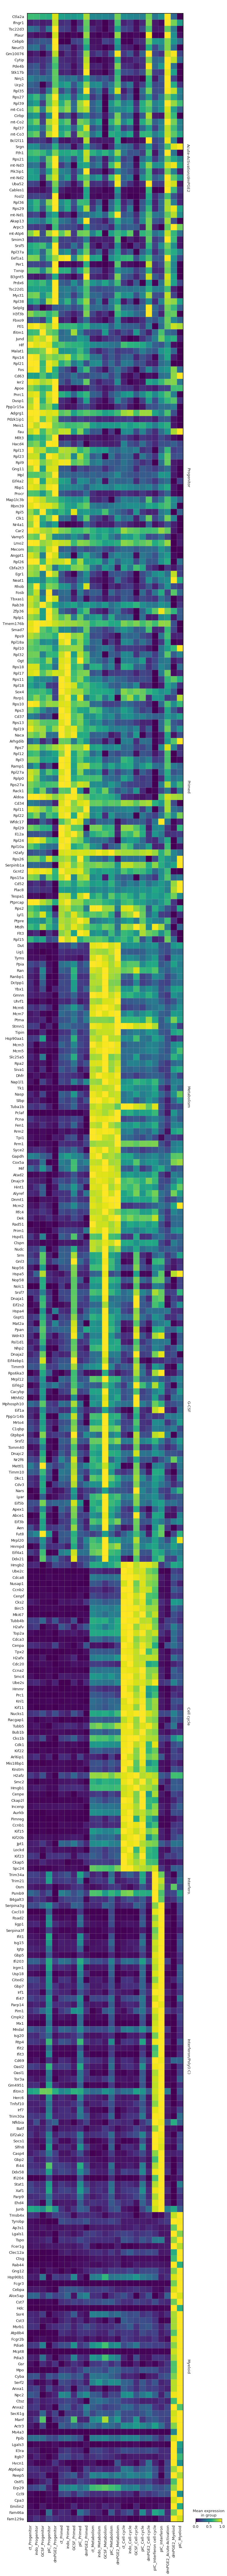

In [44]:
sc.pl.matrixplot(adata_n, marker_dic, 
                 'cluster_sample', standard_scale='var', cmap = 'viridis', swap_axes = True, save='LSKs_top50.pdf')

In [45]:
cluster_LSK = 'Progenitor'
cluster_HSC = 'Activated'

df_HSC['cell_type'] = 'HSC'
df['cell_type'] = 'LSK'

df_test_ol = df[df['specific']==cluster_LSK].append(df_HSC[df_HSC['specific']==cluster_HSC], ignore_index=True)

df_test_ol['duplicated']=df_test_ol['primerid'].duplicated(keep=False)
df_test_ol[(df_test_ol['duplicated']==False) & (df_test_ol['cell_type']=='LSK')]['primerid'].tolist()[:5]

['Ftl1', 'Ifitm1', 'Hlf', 'Malat1', 'Rps14']

In [46]:
cluster_LSK = 'Progenitor'
cluster_HSC = 'Quiescent'

df_HSC['cell_type'] = 'HSC'
df['cell_type'] = 'LSK'

df_test_ol = df[df['specific']==cluster_LSK].append(df_HSC[df_HSC['specific']==cluster_HSC], ignore_index=True)

df_test_ol['duplicated']=df_test_ol['primerid'].duplicated(keep=False)
df_test_ol[(df_test_ol['duplicated']==False) & (df_test_ol['cell_type']=='LSK')]['primerid'].tolist()[:5]

['Ftl1', 'Jund', 'Fos', 'Cd63', 'Ier2']

In [47]:
# select about overlap with HSCs as in heatmap

Metabolism_list = [ 'Hsp90aa1', 'Mcm7', 'Pcna', 'Tyms']
#30% is ok Mcm6 Dut, Tymidin synthase is part of cell cycle in HSCs'Nme1',
GCSF_list = ['Eif4ebp1',  'Hspa5', 'Srsf7','Nop56']
# d'Dnajc2','Dnaja1',Gspt1 Nme1Wdr43
Interferon_list = ['Iigp1','Isg15', 'Ifit1', 'Irf1'] 
# this is interferon/polyIC - 86% overlap

Progenitor_list = ['Mllt3', 'Fos', 'Hlf', 'Meis1']
# 'Meis1' Rps14
Primed_list = ['Sox4','Cd37','Flt3','Cd34']
#Arhgdib 'Flt3'
Interferoncellcycle_list = ['Cd47', 'Apobec1','Bdp1', 'Psmb9']
AcuteActivation_list = ['Fosl2', 'Pde4b', 'Cebpb','Tsc22d3']
#50% ol'Ifngr1'Cdkn1a
Cellcycle_list = ['Mki67', 'Top2a', 'Ccnb1', 'Plk1']
#cdk1 Ccnb2 50% Ccnb1 Plk1
Myeloid_list = ['Fcer1g' , 'Mpo', 'Ctsg', 'Cebpa' ]
#, 'Lgals1'

marker_dic = {
              'Acute-Activation/dmPGE2': AcuteActivation_list,
              'Progenitor': Progenitor_list,
              'Primed': Primed_list,
              'G-CSF'     : GCSF_list,
              'Metabolism': Metabolism_list,
              'Cell cycle': Cellcycle_list,
              'Interferon cell-cycle/Poly(I:C)': Interferoncellcycle_list,
              'Interferon/Poly(I:C)': Interferon_list,
              #'Poly(I:C)' : pIC_list,
              'Myeloid':  Myeloid_list,
               #'indo'    : indo_list
}

In [48]:
#This is to make sure genes are part of the list

cl_lists = [Metabolism_list, GCSF_list, Interferon_list, Progenitor_list, Primed_list, AcuteActivation_list, 
            Interferoncellcycle_list, Cellcycle_list, Myeloid_list]

for cl_list in cl_lists:
    boolean_series = df['primerid'].isin(cl_list).tolist()
    print(cl_list)
    print(boolean_series.count(True))

['Hsp90aa1', 'Mcm7', 'Pcna', 'Tyms']
4
['Eif4ebp1', 'Hspa5', 'Srsf7', 'Nop56']
4
['Iigp1', 'Isg15', 'Ifit1', 'Irf1']
4
['Mllt3', 'Fos', 'Hlf', 'Meis1']
4
['Sox4', 'Cd37', 'Flt3', 'Cd34']
4
['Fosl2', 'Pde4b', 'Cebpb', 'Tsc22d3']
4
['Cd47', 'Apobec1', 'Bdp1', 'Psmb9']
1
['Mki67', 'Top2a', 'Ccnb1', 'Plk1']
4
['Fcer1g', 'Mpo', 'Ctsg', 'Cebpa']
4


In [49]:
# Order of the lineage
lin = ('ct_Progenitor','indo_Progenitor','GCSF_Progenitor','pIC_Progenitor','dmPGE2_Progenitor',
       'dmPGE2_Acute-Activation',
       'ct_Primed','indo_Primed','GCSF_Primed','pIC_Primed','dmPGE2_Primed', 
       'ct_Metabolism','indo_Metabolism','GCSF_Metabolism','pIC_Metabolism', 'dmPGE2_Metabolism',
       'ct_Cell-cycle', 'indo_Cell-cycle', 'GCSF_Cell-cycle', 'pIC_Cell-cycle', 'dmPGE2_Cell-cycle',
       'pIC_Interferon cell-cycle','pIC_Interferon', 'dmPGE2_Myeloid','pIC_Myeloid')

# Reordering leiden labels using Categorical data type
adata_n.obs['cluster_sample'] = adata_n.obs['cluster_sample'].cat.reorder_categories((lin), ordered=True)

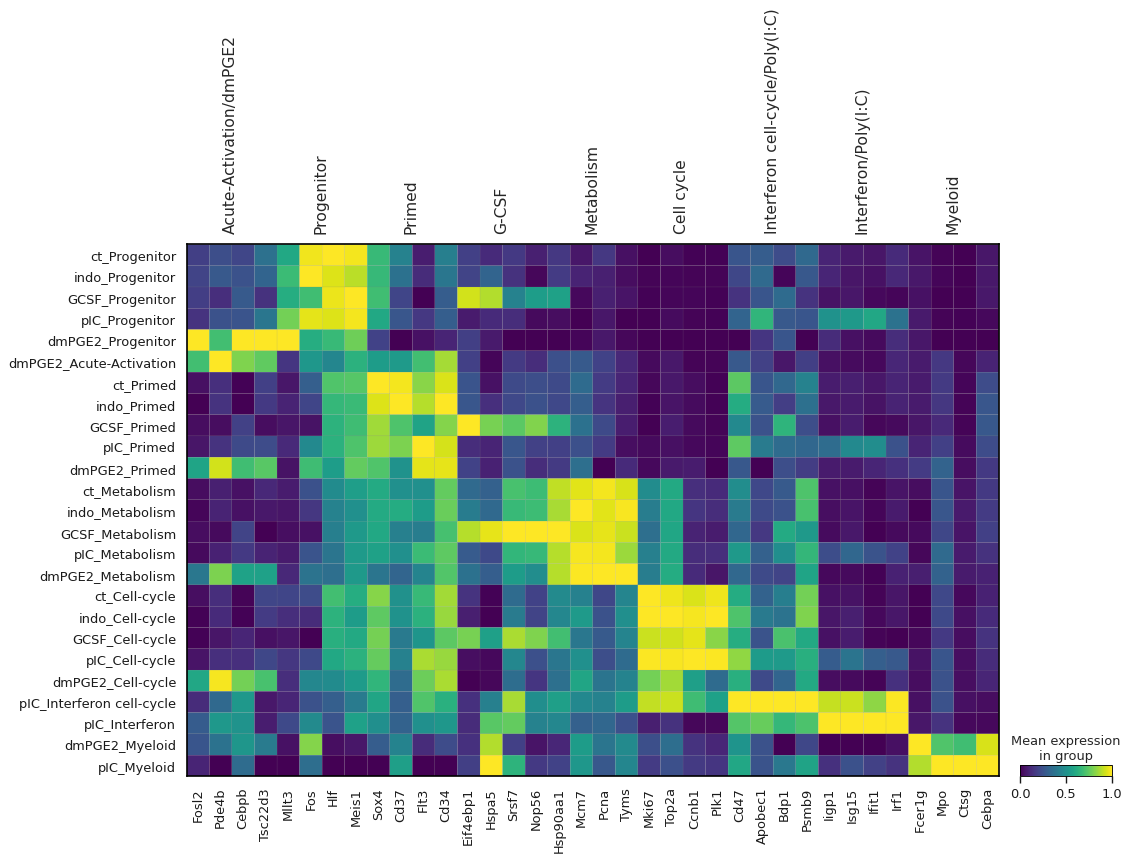

In [50]:
sc.pl.matrixplot(adata_n, marker_dic, 
                 'cluster_sample', standard_scale='var', cmap = 'viridis', save='LSKs_selected.pdf')

/opt/conda/lib/python3.9/site-packages/scanpy/plotting/_matrixplot.py:222: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  _ = ax.pcolor(_color_df, **kwds)


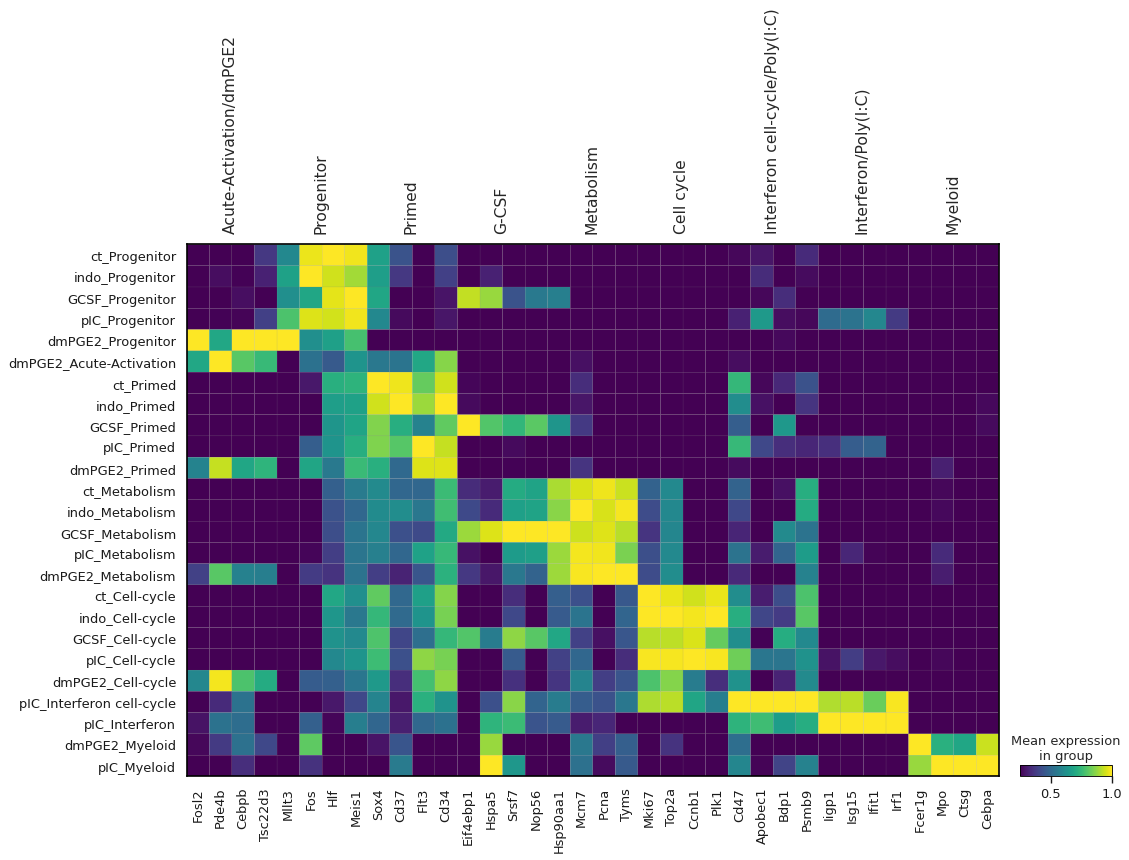

In [51]:
sc.pl.matrixplot(adata_n, marker_dic, 
                 'cluster_sample', standard_scale='var', vmin = 0.25, cmap = 'viridis', save='LSKs_selected_vmin.pdf')

In [52]:
marker_dic = {
              'Acute-Activation/dmPGE2': AcuteActivation_list,
              'Progenitor': Progenitor_list,
              'Primed': Primed_list,
              'G-CSF'     : GCSF_list,
              'Metabolism': Metabolism_list,
              'Cell cycle': Cellcycle_list,
              #'Interferon cell-cycle': Interferoncellcycle_list,
              'Interferon/Poly(I:C)': Interferon_list,
              #'Poly(I:C)' : pIC_list,
              'Myeloid':  Myeloid_list,
               #'indo'    : indo_list
}

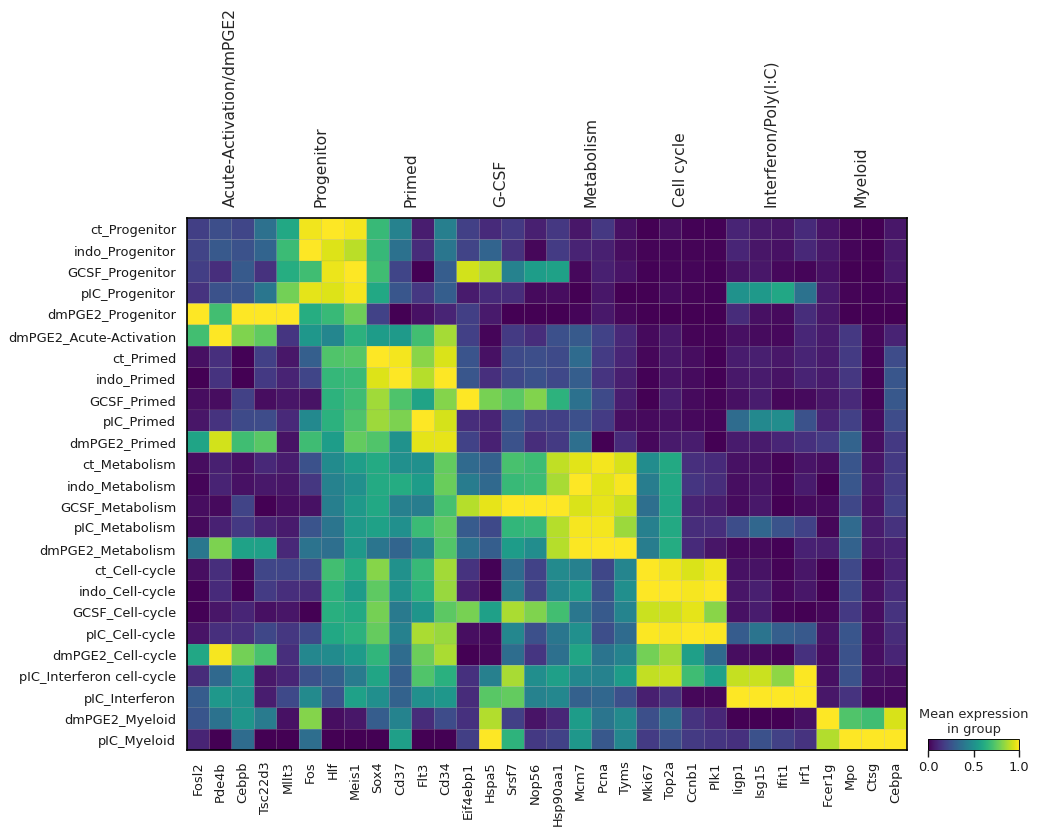

In [53]:
sc.pl.matrixplot(adata_n, marker_dic, 
                 'cluster_sample', standard_scale='var', cmap = 'viridis', save='LSKs_selected_noIcc.pdf')

/opt/conda/lib/python3.9/site-packages/scanpy/plotting/_matrixplot.py:222: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  _ = ax.pcolor(_color_df, **kwds)


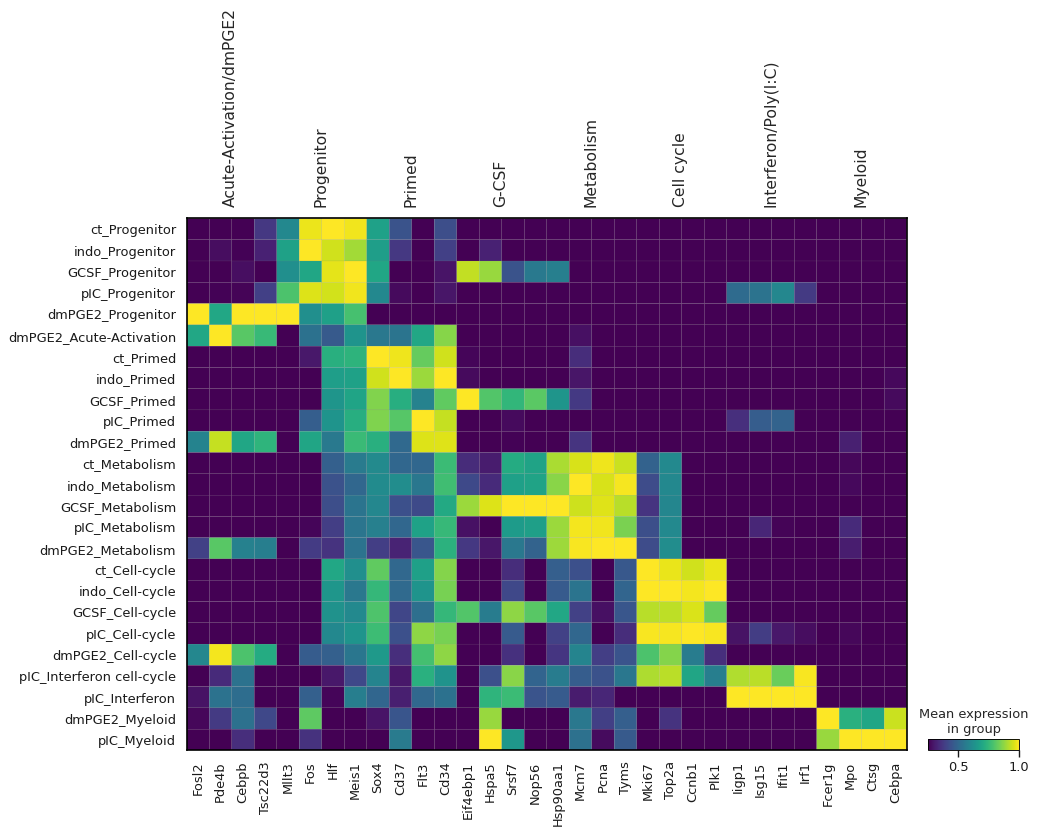

In [54]:
sc.pl.matrixplot(adata_n, marker_dic, 
                 'cluster_sample', standard_scale='var', vmin = 0.25, cmap = 'viridis', save='LSKs_selected_vmin_noIcc.pdf')

### Heatmap all

In [55]:
# calculate average expression per cluster
hvar_avg = average_expression(adata, dic_genes, gene_symbol_key=None, partition_key='cluster_sample')

In [56]:
small_clusters = adata.obs['cluster_sample'].value_counts()[adata.obs['cluster_sample'].value_counts()<20].index.tolist() 
small_clusters_remove = small_clusters.append('specific')

In [57]:
# define categories and colors for plotting (make a look up table = lut)
lut = dict(zip(hvar_avg['specific'].unique(), ['#d62728', '#8c564b', '#28B463', '#aa40fc', 
                                               '#e377c2', '#279e68', 'tab:cyan', '#b5bd61', '#1f77b4',  '#EC7063']))
row_colors = hvar_avg['specific'].map(lut)

In [58]:
z = list(set(hvar_avg.columns.tolist()) - set(small_clusters))
hvar_avg_subset = hvar_avg[z]

/opt/conda/lib/python3.9/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


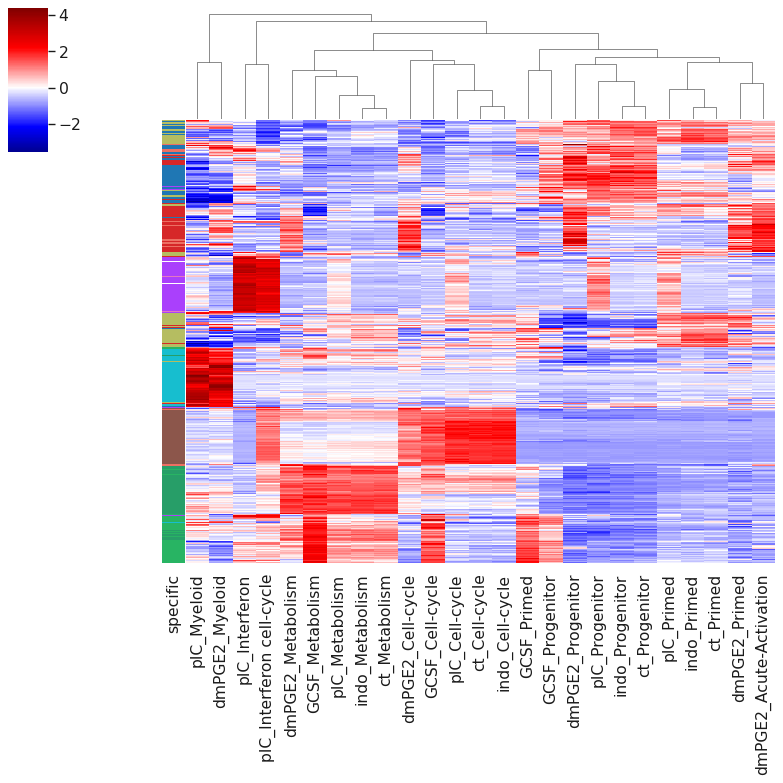

In [59]:
sns_plot = sns.clustermap(hvar_avg_subset,
                          col_cluster=True,
                          row_cluster=True,
                          z_score=0,
                          method= 'average',
                          metric = 'euclidean',
                          cmap = 'seismic',
                          xticklabels=True,
                          yticklabels=False,
                          row_colors = row_colors,
                          #vmin=-3,
                          #vmax=3,
                          center=0
                         )

sns_plot.ax_row_dendrogram.set_visible(False)
#plt.setp(sns_plot.cax.yaxis.get_majorticklabels(), fontsize=10) 
sns_plot.savefig("/home/jovyan/work/Z_TRASH/figures/LSK_combo_heatmap_aug21.pdf", dpi=300)

### Save list of common gene programs

In [60]:
HSC_tx.rename(columns={"specific": "HSC treatment"}, inplace=True)
MPP_tx.rename(columns={"specific": "LSK treatment"}, inplace=True)
HSC_cl.rename(columns={"specific": "HSC cluster"}, inplace=True)
MPP_cl.rename(columns={"specific": "LSK cluster"}, inplace=True)

cl_merge = HSC_cl.merge(MPP_cl, how='outer', on='primerid')
tx_merge = HSC_tx.merge(MPP_tx, how='outer', on='primerid')

df_final = cl_merge.merge(tx_merge, how='outer', on='primerid')
df_final.rename(columns={"primerid": "Gene"}, inplace=True)

df_final.to_csv('/home/jovyan/work/Z_TRASH/write/cluster_tx_overlap.csv', index=False, header=True)

In [61]:
df_final

,Gene,HSC cluster,LSK cluster,HSC treatment,LSK treatment
0,Ran,Metabolism,Metabolism,GCSF,GCSF
1,Eif5a,Metabolism,NaN,NaN,GCSF
2,Mif,Metabolism,Metabolism,NaN,NaN
3,Ncl,Metabolism,Metabolism,GCSF,GCSF
4,Ppia,Metabolism,Metabolism,NaN,NaN
...,...,...,...,...,...
1058,Bcl11a,NaN,NaN,NaN,pIC
1059,Ms4a6c,NaN,NaN,NaN,pIC
1060,Zc3hav1,NaN,NaN,NaN,pIC
1061,Ifit1bl1,NaN,NaN,NaN,pIC


In [62]:
df_final['LSK cluster'].value_counts()

Primed                   100
Myeloid                  100
Cell-cycle               100
Interferon               100
Acute-Activation         100
Progenitor               100
Metabolism               100
Interferon cell-cycle      5
Name: LSK cluster, dtype: int64

In [63]:
%pip list

Package                       Version
----------------------------- -------------------
alembic                       1.6.0
anndata                       0.7.6
annoy                         1.17.0
anyio                         2.2.0
appdirs                       1.4.4
argon2-cffi                   20.1.0
async-generator               1.10
attrs                         20.3.0
Babel                         2.9.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
beautifulsoup4                4.9.3
bleach                        3.3.0
blinker                       1.4
bokeh                         2.3.1
Bottleneck                    1.3.2
brotlipy                      0.7.0
cached-property               1.5.2
cellbrowser                   0.7.7
certifi                       2020.12.5
certipy                       0.1.3
cffi                          1.14.5
chardet                       4.0.0
click                         7.1.2
cloudpickle                   1.6.0
conda  

In [64]:
sc.logging.print_versions()
pd.show_versions()

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.6
scanpy      1.7.2
sinfo       0.3.4
-----
PIL                 8.1.2
anyio               NA
argon2              20.1.0
attr                20.3.0
babel               2.9.1
backcall            0.2.0
bottleneck          1.3.2
brotli              NA
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.04.1
dateutil            2.8.1
de